This script was modified from the "General.ipynb" script, which was created for the purpose of benchmarking of ML methods. This script is meant to train the same networks present in "General.ipynb" with the same training set, and classify the new data collected with belt.

Created by Samuel Horovatin, February 2022

In [43]:
# Data Processing Imports
import pandas as pd
import os
from skimage.transform import resize, rotate, resize 
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import glob
import csv

# Logger Imports
import time
import logging
import sys
from logging.handlers import TimedRotatingFileHandler

# Model Specific Imports
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from skimage import data, io
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

# Visulaization and metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [2]:
# Sets up all standardized logger stuff
FORMATTER = logging.Formatter("%(asctime)s —  %(levelname)s — %(message)s")
LOG_FILE = "General_Script_Full_Set.log"

def get_console_handler():
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(FORMATTER)
    return console_handler

def get_file_handler():
    file_handler = TimedRotatingFileHandler(LOG_FILE, when='midnight')
    file_handler.setFormatter(FORMATTER)
    return file_handler

def get_logger(logger_name):
    logger = logging.getLogger(logger_name)
    
    if (logger.hasHandlers()): # important as removes duplicate loggers (and thus duplicate log entries)
        logger.handlers.clear()
    logger.setLevel(logging.DEBUG) # better to have too much log than not enough
    logger.addHandler(get_console_handler())
    logger.addHandler(get_file_handler())
    # with this pattern, it's rarely necessary to propagate the error up to parent
    logger.propagate = False
    return logger

logger = get_logger("General_Script")

In [3]:
# Lays out all training data paths. 
# NOTE, the folder in which the img's are stored in dictates there health class. See comments for folder class

Categories_Durum=['CFP-CK1','CFP-CK2'] # [Infected, Healthy]
Categories_Bread=['CFP-CK3','CFP-CK4'] # [Infected, Healthy]
Categories_Test_B179 = ['CFP-B179-A','CFP-B179-B'] # [Infected, Healthy]
Categories_Test_B223 = ['CFP-B223-A','CFP-B223-B'] # [Infected, Healthy]

Infected_Categories = ['CFP-CK1', 'CFP-CK3', 'CFP-B179-A', 'CFP-B223-A']

All_Categories = [Categories_Durum, Categories_Bread, Categories_Test_B179, Categories_Test_B223]

datadir='/birl2/users/sch923/Thesis/Data/Wheat/TestSamples' 
#path which contains all the categories of images

In [20]:
# Pre-processing step and loading of all training data

img_arr, label_arr = [],[]
total_imgs, total_infected, total_healthy = 0, 0, 0


# creating species specific data sets
for Categories in All_Categories:
    img_arr.append(list())
    label_arr.append(list())
    
    for i in Categories:
        logger.info(f'loading category: {i}')    
        path=os.path.join(datadir,i) 
        image_count = 0
        
        for img_path in os.listdir(path):  
            img=imread(os.path.join(path,img_path))
            img_resized=resize(img,(150,150,3))  
            img_arr[len(img_arr)-1].append(img_resized) # Saves images
            label_arr[len(img_arr)-1].append(Categories.index(i)) # Applies category based on folder
            image_count += 1
            
        logger.info(f'loaded category: {i} successfully, found {image_count} images')

        # Entire Dataset metric collection
        total_imgs = total_imgs + image_count
        if i in Infected_Categories:
            total_infected = total_infected + image_count
        else:
            total_healthy = total_healthy + image_count

logger.info(f'Number Of Healthy Kernel Images Found: {total_healthy}')            
logger.info(f'Number Of Infected Kernel Images Found: {total_infected}')
logger.info(f'Total Number Of Images Found: {total_imgs}')

2022-02-06 10:51:56,041 —  INFO — loading category: CFP-CK1
2022-02-06 10:52:02,101 —  INFO — loaded category: CFP-CK1 successfully, found 43 images
2022-02-06 10:52:02,102 —  INFO — loading category: CFP-CK2
2022-02-06 10:52:09,607 —  INFO — loaded category: CFP-CK2 successfully, found 48 images
2022-02-06 10:52:09,608 —  INFO — loading category: CFP-CK3
2022-02-06 10:52:13,018 —  INFO — loaded category: CFP-CK3 successfully, found 24 images
2022-02-06 10:52:13,019 —  INFO — loading category: CFP-CK4
2022-02-06 10:52:17,372 —  INFO — loaded category: CFP-CK4 successfully, found 31 images
2022-02-06 10:52:17,372 —  INFO — loading category: CFP-B179-A
2022-02-06 10:52:21,493 —  INFO — loaded category: CFP-B179-A successfully, found 29 images
2022-02-06 10:52:21,494 —  INFO — loading category: CFP-B179-B
2022-02-06 10:52:31,866 —  INFO — loaded category: CFP-B179-B successfully, found 74 images
2022-02-06 10:52:31,867 —  INFO — loading category: CFP-B223-A
2022-02-06 10:52:33,830 —  INFO

In [36]:
# Image flattening for training data
logger.info(f'Flattening images...')
flat_arr = []

for group in img_arr:
    flat_arr.append(list())
    for img in group:
        flat_img = img.flatten()
        flat_arr[len(flat_arr)-1].append(flat_img)        
        
logger.info(f'Image flattening complete!')


2022-02-06 11:03:23,165 —  INFO — Flattening images...
2022-02-06 11:03:23,229 —  INFO — Image flattening complete!


In [37]:
# Slicing of input data into seperate dataframes (two for each data set), one containing image data and the other containing class data

list_arr_fun = lambda l : np.array(l)
flat_img_list=list(map(list_arr_fun, flat_arr))
label_img_list=list(map(list_arr_fun, label_arr))

df_Training=pd.DataFrame(np.append(flat_img_list[0], flat_img_list[1], axis=0))

df_Training['label']=np.append(label_img_list[0], label_img_list[1], axis=0)

x_Training=df_Training.iloc[:,:-1] # Image data 
y_Training=df_Training.iloc[:,-1] # Label data

# Creates test and training split
logger.info('======= Start Of Data Split =======')
x_train,x_test,y_train,y_test=train_test_split(x_Training,y_Training, test_size=0.01,random_state=77,stratify=y_Training)
# We want all the images included in training set, thus the training and test sets are concatinated
x_train = pd.concat([x_train, x_test]) 
y_train = pd.concat([y_train, y_test])
logger.info(f'Splitted Successfully. Training Set Length = {len(y_train)}')

logger.info('Test Splitted Successfully')
logger.info('======= End Of Data Split =======\n')


2022-02-06 11:03:26,573 —  INFO — ======= Start Of Data Split =======
2022-02-06 11:03:26,639 —  INFO — Splitted Successfully. Training Set Length = 146
2022-02-06 11:03:26,640 —  INFO — Test Splitted Successfully
2022-02-06 11:03:26,640 —  INFO — ======= End Of Data Split =======



In [38]:
# A generalized model that trains a given model, gathering time complexity stats about its training.

def modelTrainer(model, x_train, y_train, model_name, method_name):

    # Added StandardScaler step to model training pipeline to help with ML (Specifically Logical Regression) convergence problems.
    pipe = make_pipeline(StandardScaler(), model)
    logger.info(f"Starting to train {method_name} model...")
    start = time.time()
    pipe.fit(x_train,y_train)
    end = time.time()
    logger.info(f"The {model_name} model trained in: {str(end - start)} seconds")

In [39]:
# Train all models

logger.info('======= Start Of Logistic Regression Model Generation =======')
LogR_param_grid={'penalty':['l2'], 'C':[0.1,1,10,100], 'max_iter':[1024], 'solver': ['lbfgs'] } 
LogR_model=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
modelTrainer(LogR_model, x_train, y_train, "LogR", "LogR")

logger.info('======= Start Of SVM Model Generation =======')
SVM_param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
SVM_model=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
modelTrainer(SVM_model, x_train, y_train, "SVM", "SVM")

logger.info('======= Start Of K Nearest Neighbors Model Generation =======')
KNN_param_grid={'n_neighbors':[5], 'weights':['uniform', 'distance']}
KNN_model=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
modelTrainer(KNN_model, x_train, y_train, "KNN", "KNN")

logger.info('======= Start Of Random Forest Model Generation =======')
RanF_param_grid={'n_estimators':[100], 'criterion': ['gini', 'entropy']}
RanF_model=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
modelTrainer(RanF_model, x_train, y_train, "RanF", "RanF")

2022-02-06 11:03:31,653 —  INFO — ======= Start Of Logistic Regression Model Generation =======
2022-02-06 11:03:31,655 —  INFO — Starting to train LogR model...
2022-02-06 11:03:41,287 —  INFO — The LogR model trained in: 9.631323337554932 seconds
2022-02-06 11:03:41,288 —  INFO — ======= Start Of SVM Model Generation =======
2022-02-06 11:03:41,289 —  INFO — Starting to train SVM model...
2022-02-06 11:04:57,225 —  INFO — The SVM model trained in: 75.93460512161255 seconds
2022-02-06 11:04:57,227 —  INFO — ======= Start Of K Nearest Neighbors Model Generation =======
2022-02-06 11:04:57,230 —  INFO — Starting to train KNN model...
2022-02-06 11:04:58,419 —  INFO — The KNN model trained in: 1.1884698867797852 seconds
2022-02-06 11:04:58,419 —  INFO — ======= Start Of Random Forest Model Generation =======
2022-02-06 11:04:58,421 —  INFO — Starting to train RanF model...
2022-02-06 11:05:00,798 —  INFO — The RanF model trained in: 2.3771626949310303 seconds


In [47]:
# Specifying the location of data to be evaluated by the models.

Eval_Inpath = "/birl2/users/sch923/Thesis/Data/phenoSEEDOutput"
Eval_Labels = "/birl2/users/sch923/Thesis/Data/UGRep2FDK.txt"
Eval_Extension = '*.jpg'

In [76]:
# Collect all images (in the form of .npz) to be evaluated by the networks
Evale_Images_Paths = glob.glob(os.path.join(Eval_Inpath, '**', Eval_Extension), recursive=True)
if len(Evale_Images_Paths) == 0:
    logging.error(f' there are no {Eval_Extension} found in supplied directory: \n{Eval_Inpath}')


# Preform an identical pre-procesisng step as images used for training.
Eval_img_tuple_arr= [] # contains lot name, resized image
for img_path in Evale_Images_Paths:
    img=imread(os.path.join(path,img_path))
    Eval_img_resized = resize(img,(150,150,3))
    Eval_flat_img = Eval_img_resized.flatten()
    Eval_flat_img_arr = np.array(Eval_flat_img)
    Eval_flat_df=pd.DataFrame(Eval_flat_img_arr)

    lot_name = img_path.split('/')[-3] # Based on the file path we can derive the lot name  
    Eval_img_tuple_arr.append((lot_name, Eval_flat_df)) # Saves flat images


logger.info(f'Successfully loaded evaluation images, found {len(Eval_img_tuple_arr)} images')

2022-02-06 13:03:06,053 —  INFO — Successfully loaded evaluation images, found 46586 images


In [71]:
# Get all image metadata
Eval_Label_df = pd.read_csv(Eval_Labels, delimiter='\t')
print(Eval_Label_df.columns)

Index(['CN', 'Abbrev.', 'Greenhouse Entry', 'Tall/Short', 'U of G FDK',
       'U of G FDK%', 'UofG Imaging #'],
      dtype='object')


label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Regression, pred: [0]
label: 66-T, model: Logistic Re

KeyboardInterrupt: 

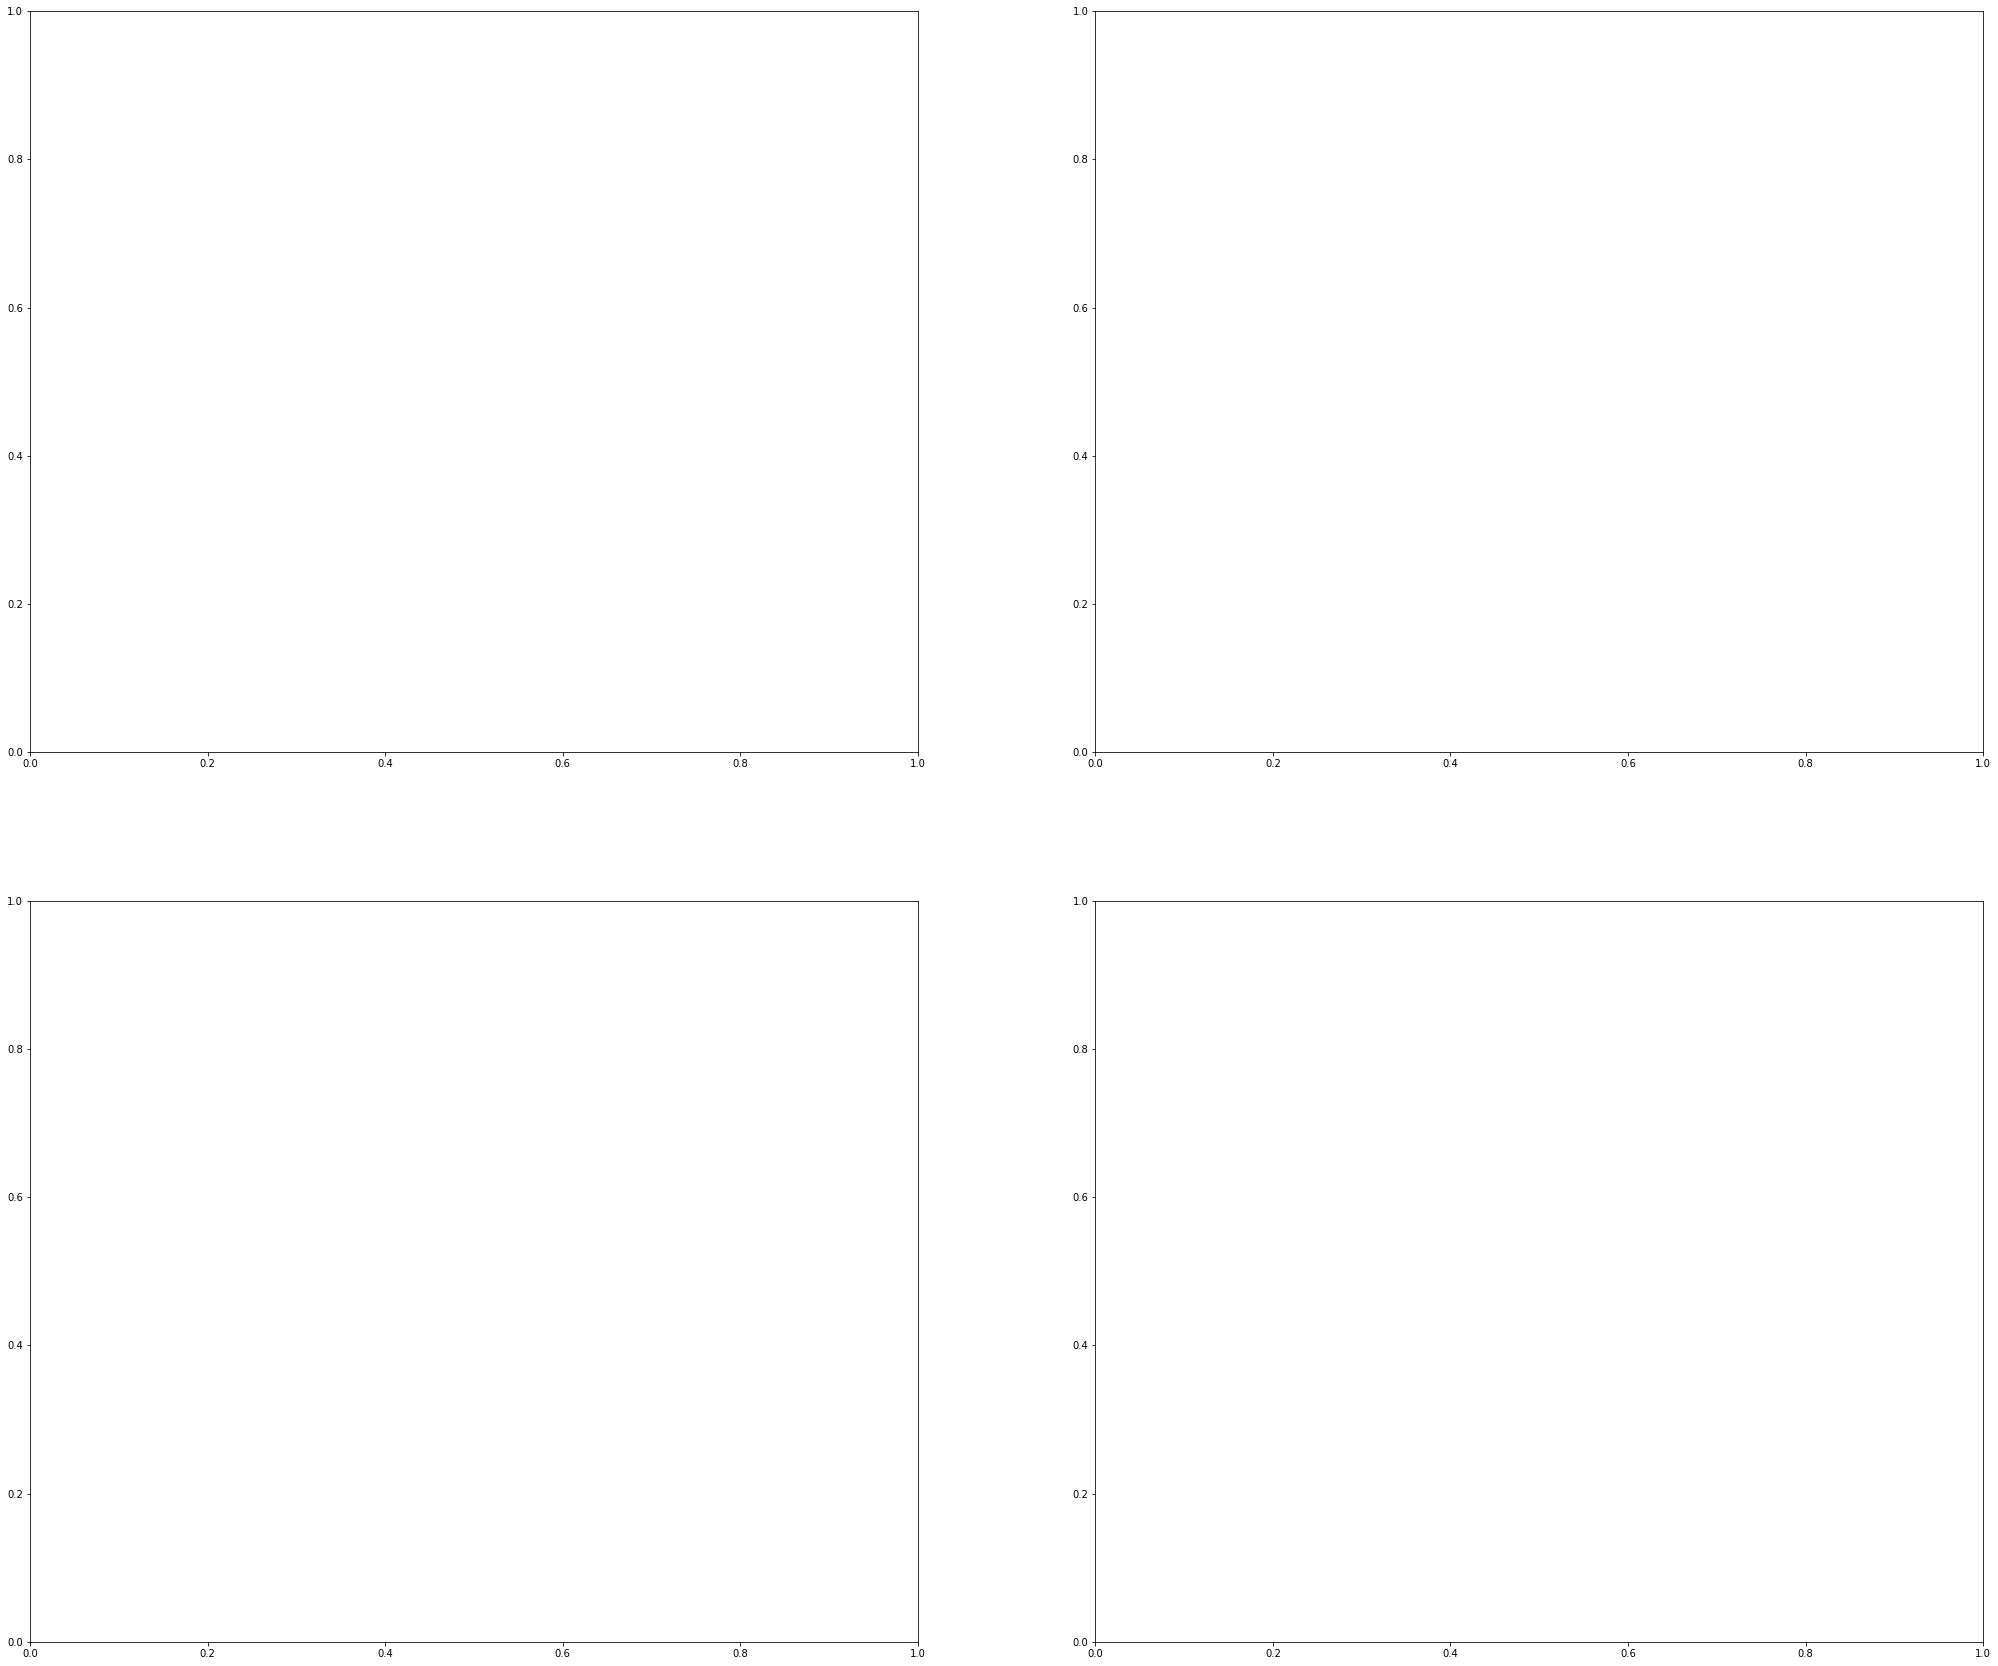

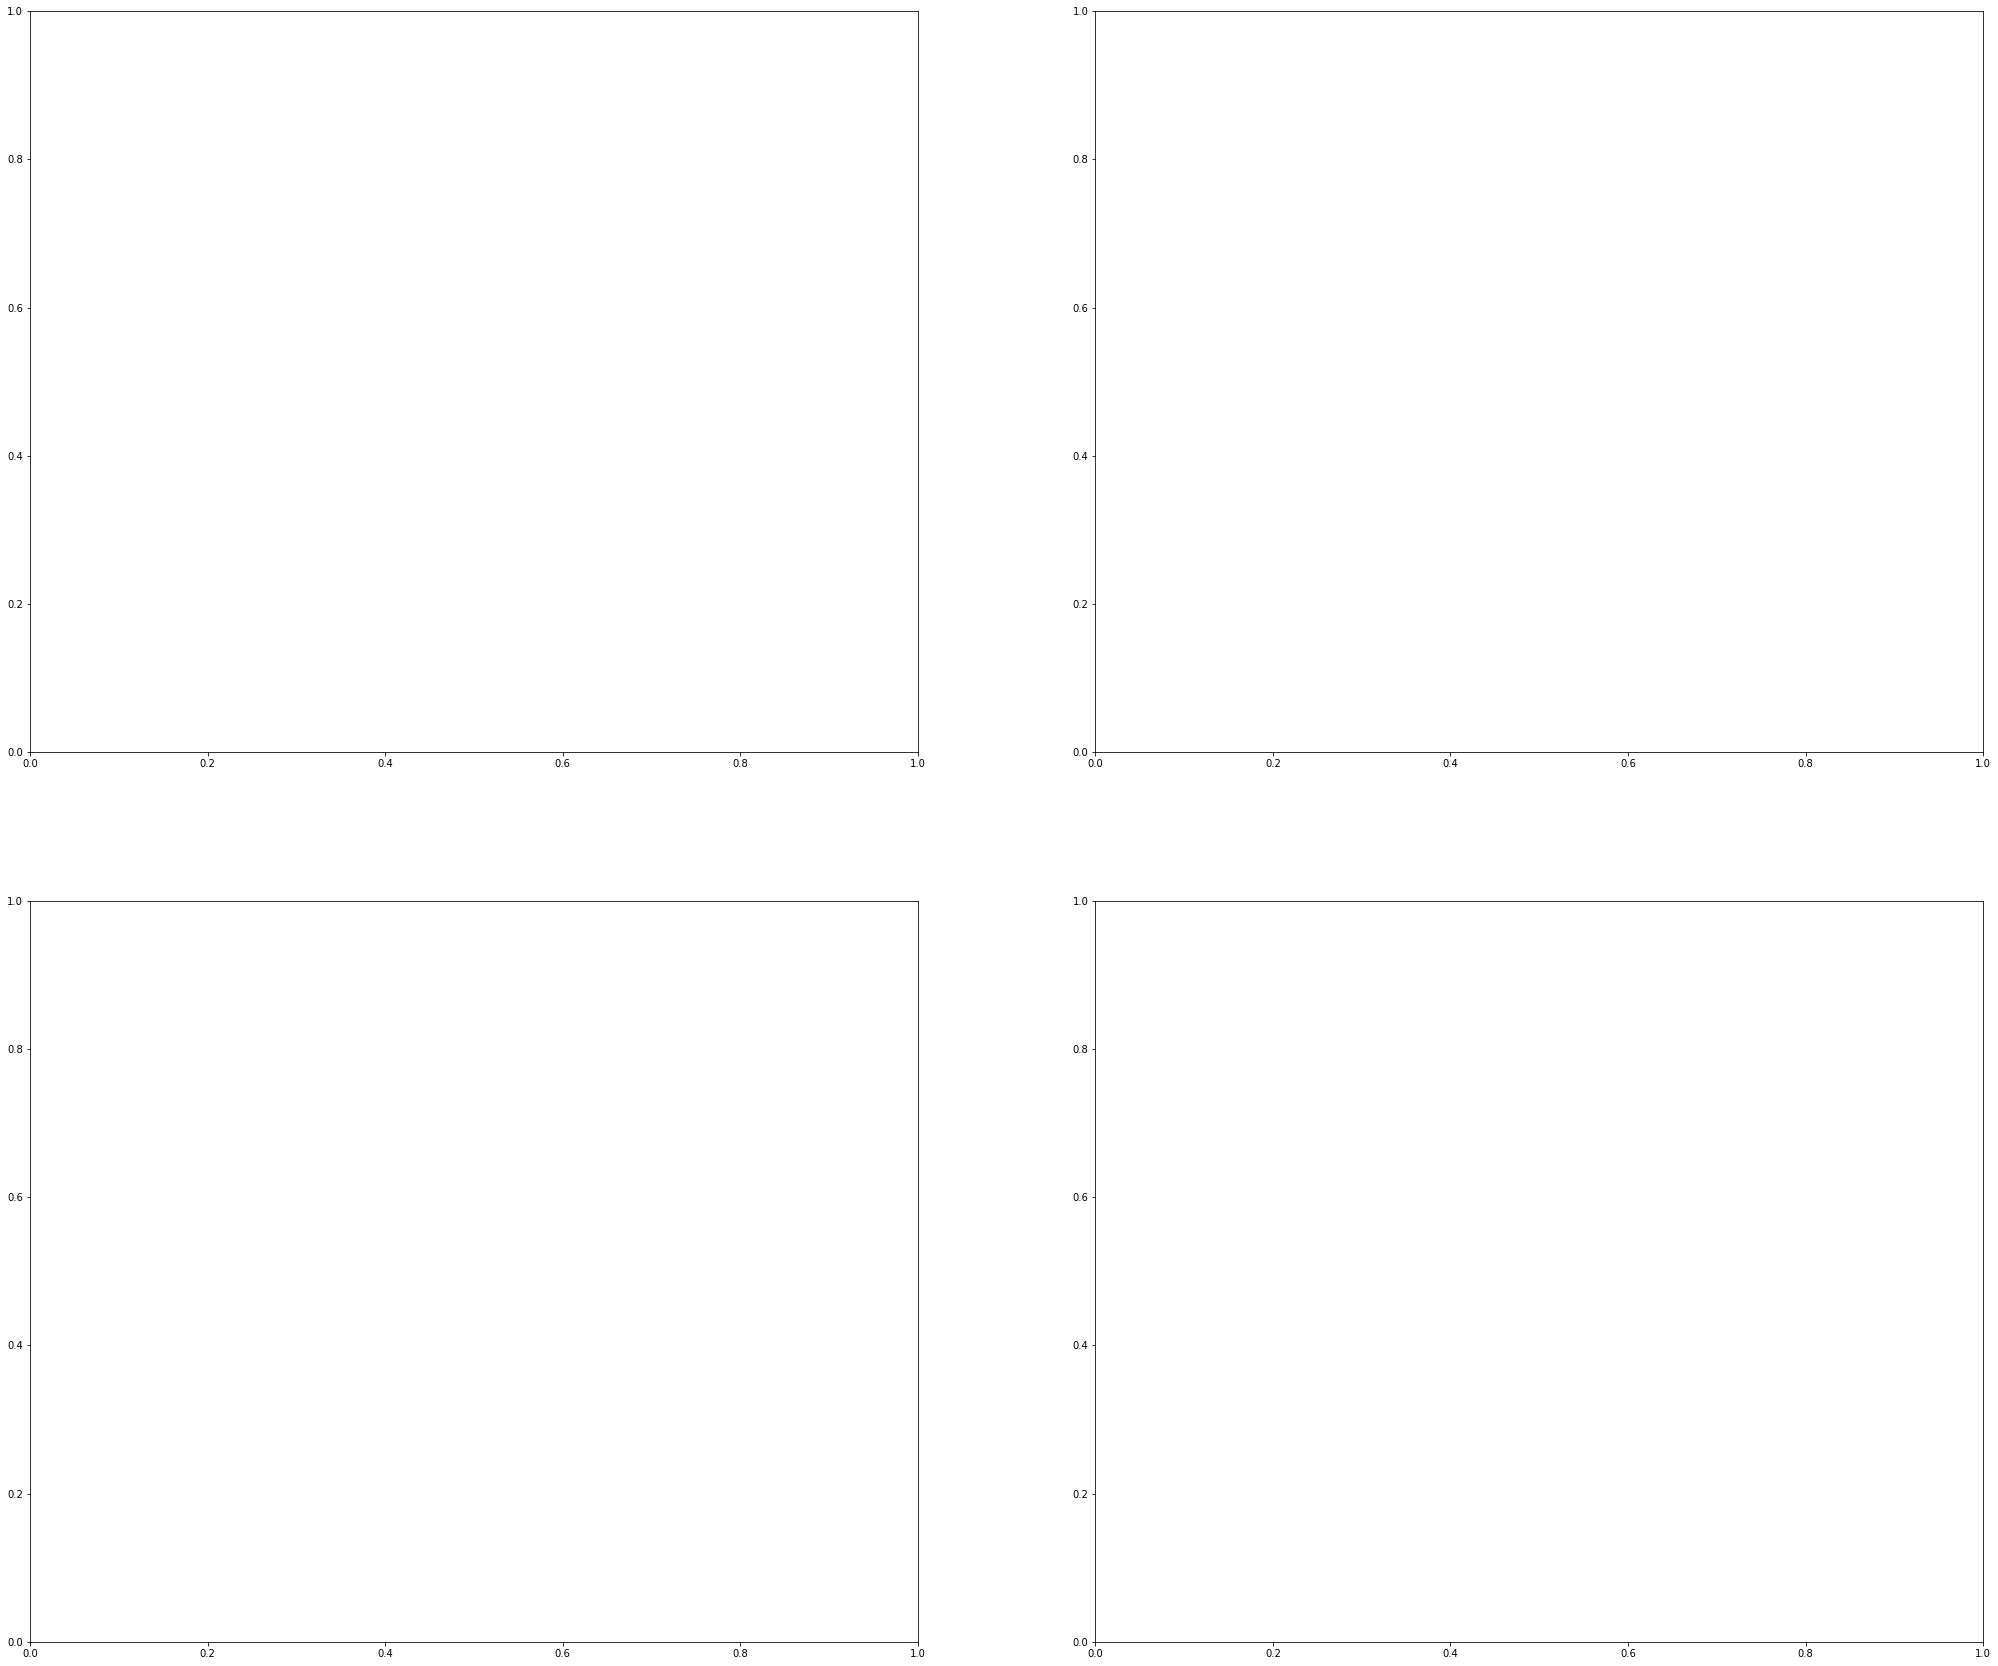

In [81]:
# Come common metrics used to gauge the models preformance
classification_model = []
train_data_used = []
test_data_used = []
false_positive_rate = [] # fp / (fp + tn)
false_negative_rate = [] # fn / (tp + fn)
true_negative_rate = [] # tn / (tn + fp)
negative_predictive_value = [] # tn / (tn + fn)
false_discovery_rate = [] # fp / (tp + fp)
true_positive_rate = [] # tp / (tp + fn)
precision = [] # tp / (tp + fp)
accuracy = [] # (tp + tn) / (tp + fp + fn + tn) 
f1_score = [] 
f2_score = []

# Setting up grid style plots for confusion matrix (conf) and ROC curves
fig_conf, axes_conf = plt.subplots(nrows=2, ncols=2, figsize=(35,30))
fig_roc, axes_roc = plt.subplots(nrows=2, ncols=2, figsize=(35,30))
axes_conf = axes_conf.flatten()
axes_roc = axes_roc.flatten()

# Labelling for plots
Model_Label = ['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors', 'Random Forest']
Trained_Models = [LogR_model, SVM_model, KNN_model, RanF_model]
Infected_dict = dict()
Count_dict = dict()
for model_name, model in zip(Model_Label, Trained_Models):
    for (label, img) in Eval_img_tuple_arr:

        if not label in Infected_dict.keys():
            Infected_dict[label]=0
        if not label in Count_dict.keys():
            Count_dict[label]=0
        # TODO constantly predicting 0 infection, need to look into why.
        pred = model.predict(img.T)
        print(f"label: {label}, model: {model_name}, pred: {pred}")     


